In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import numpy as np
import os
import time
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.layers import Dense, Activation, Flatten, GlobalMaxPooling2D, Dropout
from keras.layers import merge, Input
from keras.models import Model
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.layers import GlobalAveragePooling2D, Dense, ReLU

In [ ]:
data_path = '/content/drive/My Drive/transfer_learning_data/cat_dog_horse_human/'
X_train = np.load(data_path+'x_train.npy').astype(float)
Y_train = np.load(data_path+'y_train.npy').astype(float)
X_test = np.load(data_path+'x_test.npy').astype(float)
Y_test = np.load(data_path+'y_test.npy').astype(float)

In [ ]:
num_classes = 4
names = ['cats', 'dogs', 'horses', 'humans']

In [ ]:
print('Training Data: {}'.format(X_train.shape))
print('Test Data: {}'.format(X_test.shape))

Training Data: (646, 224, 224, 3)
Test Data: (162, 224, 224, 3)


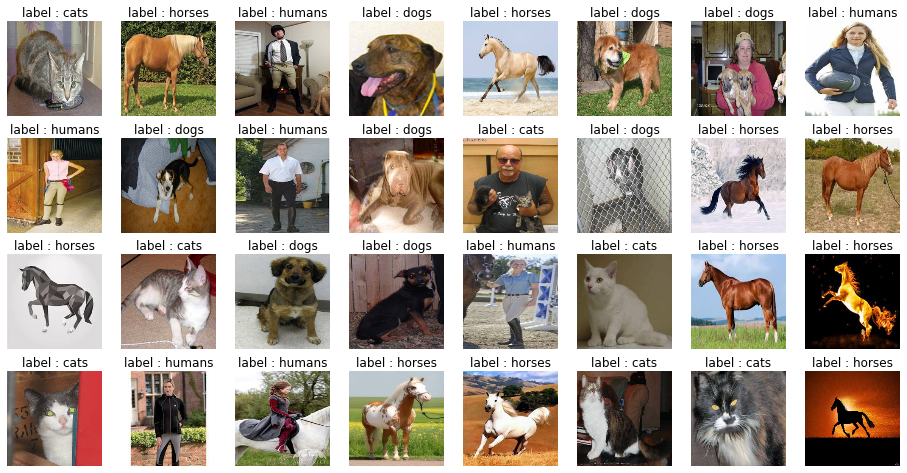

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,8))
for k in range(32):
    img = X_train[k]
    label = Y_train[k]
    plt.subplot(4,8,1+k)
    plt.imshow(img)
    plt.axis('off')
    plt.title('label : {0}'.format(names[np.argmax(label)]))
plt.show()

In [ ]:
model = MobileNetV2(include_top=False, weights='imagenet')
model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_3[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, None, None, 3 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, None, None, 3 128         Conv1[0][0]                      
_______________________________________________________________________________

In [ ]:
x=GlobalAveragePooling2D()(model.output)
x=Dense(512,activation=ReLU(6.),name='fc-1')(x)
x=Dropout(0.5)(x)
x=Dense(256,activation=ReLU(6.),name='fc-2')(x)
x=Dropout(0.5)(x)
x=Dense(128,activation=ReLU(6.),name='fc-3')(x)
x=Dropout(0.5)(x)

# a softmax layer for 4 classes
out=Dense(num_classes,activation='softmax',name='output_layer')(x)

custom_mobilenetv2_model = Model(model.input, out)

# freeze all the layers except the dense layers
for layer in custom_mobilenetv2_model.layers[:-3]:
  layer.trainable=False

custom_mobilenetv2_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

custom_mobilenetv2_model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_3[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, None, None, 3 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, None, None, 3 128         Conv1[0][0]                      
_______________________________________________________________________________________

In [ ]:
n_epochs = 50
n_batch = 32

In [ ]:
#from keras.callbacks import EarlyStopping, ModelCheckpoint
#es = EarlyStopping()
#mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
t=time.time()
#hist = custom_mobilenetv2_model.fit(X_train, Y_train, batch_size=n_batch, epochs=n_epochs, verbose=1, validation_data=(X_test, Y_test), callbacks=[es, mc])
hist = custom_mobilenetv2_model.fit(X_train, Y_train, batch_size=n_batch, epochs=n_epochs, verbose=1, validation_data=(X_test, Y_test))
print('Training time: %s' % (t - time.time()))

Epoch 1/50
21/21 [==============================] - 2s 83ms/step - loss: 1.7835 - accuracy: 0.2771 - val_loss: 1.2970 - val_accuracy: 0.4815
Epoch 2/50
21/21 [==============================] - 1s 49ms/step - loss: 1.4818 - accuracy: 0.3359 - val_loss: 1.1367 - val_accuracy: 0.6975
Epoch 3/50
21/21 [==============================] - 1s 49ms/step - loss: 1.3200 - accuracy: 0.4133 - val_loss: 1.0490 - val_accuracy: 0.7222
Epoch 4/50
21/21 [==============================] - 1s 49ms/step - loss: 1.1743 - accuracy: 0.4907 - val_loss: 0.9561 - val_accuracy: 0.8025
Epoch 5/50
21/21 [==============================] - 1s 49ms/step - loss: 1.1118 - accuracy: 0.5186 - val_loss: 0.8886 - val_accuracy: 0.8333
Epoch 6/50
21/21 [==============================] - 1s 49ms/step - loss: 1.0678 - accuracy: 0.5805 - val_loss: 0.8344 - val_accuracy: 0.8148
Epoch 7/50
21/21 [==============================] - 1s 49ms/step - loss: 1.0146 - accuracy: 0.6022 - val_loss: 0.7566 - val_accuracy: 0.8765
Epoch 8/50
21

In [ ]:
(loss, accuracy) = custom_mobilenetv2_model.evaluate(X_test, Y_test, batch_size=n_batch, verbose=1)

print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss,accuracy * 100))

6/6 [==============================] - 0s 27ms/step - loss: 0.3988 - accuracy: 0.9383
[INFO] loss=0.3988, accuracy: 93.8272%


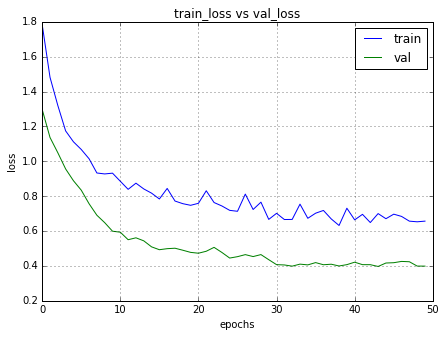

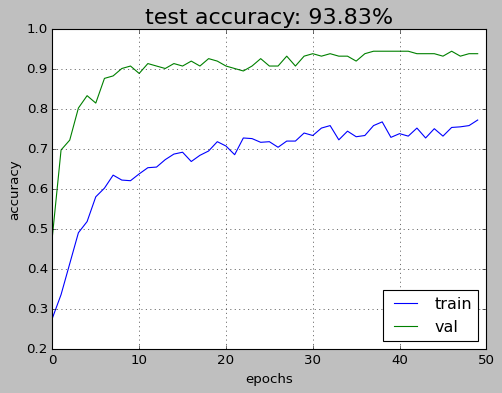

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline
# visualizing losses and accuracy
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['accuracy']
val_acc=hist.history['val_accuracy']
xc=range(len(train_loss))

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('test accuracy: {:.2f}%'.format(accuracy*100), fontsize=20)
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.show()